# 3_data_exploration/02_geographic_analysis.ipynb
"""
# Geographic Analysis of Satellite Observation Success

## Goal
Analyze how ground station location and characteristics affect observation success rates.

## Research Questions
1. Are there geographic patterns in observation success rates?
2. Does station altitude affect success?
3. Do stations with higher horizons have better success rates?
4. Are there regional clusters of highly successful stations?
5. How does hemisphere (northern vs southern) affect success?

## Analysis Plan
1. **Geographic Distribution**: Map station locations and success rates
2. **Altitude Analysis**: Success rates vs station elevation
3. **Horizon Analysis**: Minimum elevation angle vs success
4. **Regional Patterns**: Success by continent/country (using grid squares)
5. **Hemisphere Comparison**: Northern vs southern hemisphere success rates

## Expected Outputs
- Geographic maps showing success patterns
- Statistical analysis of location-based factors
- Insights for station selection and deployment
"""

In [1]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.cm as cm

print("="*80)
print("📍 GEOGRAPHIC ANALYSIS OF SATELLITE OBSERVATIONS")
print("="*80)
print(f"Execution started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Working directory: {os.getcwd()}")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

# Create output directory
geo_plot_dir = "geo_plots"
os.makedirs(geo_plot_dir, exist_ok=True)

📍 GEOGRAPHIC ANALYSIS OF SATELLITE OBSERVATIONS
Execution started: 2025-12-12 14:14:09
Working directory: d:\ELO 2\satnogs_project\satellite-pass-prediction\3_data_exploration


In [2]:
# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING AND PREPARING DATA")
print("="*80)

# Load the dataset (same sample as previous EDA for consistency)
sample_path = "../1_datasets/processed/four_year_sample_50000.csv"
print(f"Loading dataset: {sample_path}")

try:
    df = pd.read_csv(sample_path)
    print(f"✅ Dataset loaded: {len(df):,} observations")
    
    # Ensure target is numeric
    if 'target_success' in df.columns:
        df['target_success'] = df['target_success'].astype(int)
    
    print(f"✅ Success rate: {df['target_success'].mean() * 100:.2f}%")
    
except FileNotFoundError:
    print(f"❌ Sample file not found. Loading full dataset...")
    full_path = "../1_datasets/processed/four_year_observations_20251211_1730.csv"
    df = pd.read_csv(full_path, nrows=50000)  # Load first 50K for speed
    df['target_success'] = df['target_success'].astype(int)
    print(f"✅ Loaded 50,000 rows from full dataset")

# Check for required geographic columns
required_cols = ['station_lat', 'station_lng', 'station_alt', 'horizon']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"⚠️  Missing geographic columns: {missing_cols}")
    print("   Geographic analysis may be limited")
else:
    print(f"✅ All geographic columns available")
    print(f"   Stations with location data: {df['station_lat'].notnull().sum():,}")
    print(f"   Stations with altitude data: {df['station_alt'].notnull().sum():,}")
    print(f"   Stations with horizon data: {df['horizon'].notnull().sum():,}")

# Create geographic analysis dataframe
geo_df = df.copy()

# Filter to rows with geographic data
if 'station_lat' in geo_df.columns:
    geo_df = geo_df[geo_df['station_lat'].notnull() & geo_df['station_lng'].notnull()]
    print(f"\n📊 Geographic data available for: {len(geo_df):,} observations")


STEP 1: LOADING AND PREPARING DATA
Loading dataset: ../1_datasets/processed/four_year_sample_50000.csv
✅ Dataset loaded: 50,000 observations
✅ Success rate: 49.33%
✅ All geographic columns available
   Stations with location data: 50,000
   Stations with altitude data: 50,000
   Stations with horizon data: 50,000

📊 Geographic data available for: 50,000 observations


In [3]:
# ============================================================================
# STEP 2: BASIC GEOGRAPHIC STATISTICS
# ============================================================================
print("\n" + "="*80)
print("STEP 2: BASIC GEOGRAPHIC STATISTICS")
print("="*80)

if 'station_lat' in geo_df.columns:
    # Calculate basic statistics
    print("🌍 Geographic Coverage Statistics:")
    print(f"   • Latitude range: {geo_df['station_lat'].min():.2f}° to {geo_df['station_lat'].max():.2f}°")
    print(f"   • Longitude range: {geo_df['station_lng'].min():.2f}° to {geo_df['station_lng'].max():.2f}°")
    print(f"   • Unique station locations: {geo_df[['station_lat', 'station_lng']].drop_duplicates().shape[0]:,}")
    
    # Hemisphere distribution
    northern = (geo_df['station_lat'] >= 0).sum()
    southern = (geo_df['station_lat'] < 0).sum()
    print(f"   • Northern hemisphere stations: {northern:,} ({northern/len(geo_df)*100:.1f}%)")
    print(f"   • Southern hemisphere stations: {southern:,} ({southern/len(geo_df)*100:.1f}%)")
    
    # Success rate by hemisphere
    if 'target_success' in geo_df.columns:
        north_success = geo_df[geo_df['station_lat'] >= 0]['target_success'].mean() * 100
        south_success = geo_df[geo_df['station_lat'] < 0]['target_success'].mean() * 100
        print(f"\n🎯 Success Rate by Hemisphere:")
        print(f"   • Northern: {north_success:.1f}%")
        print(f"   • Southern: {south_success:.1f}%")
        print(f"   • Difference: {abs(north_success - south_success):.1f} percentage points")

if 'station_alt' in geo_df.columns:
    print(f"\n🏔️  Station Altitude Statistics:")
    print(f"   • Minimum altitude: {geo_df['station_alt'].min():.0f} meters")
    print(f"   • Maximum altitude: {geo_df['station_alt'].max():.0f} meters")
    print(f"   • Average altitude: {geo_df['station_alt'].mean():.0f} meters")
    print(f"   • Median altitude: {geo_df['station_alt'].median():.0f} meters")

if 'horizon' in geo_df.columns:
    print(f"\n🌅 Station Horizon Statistics:")
    print(f"   • Minimum horizon: {geo_df['horizon'].min():.0f}°")
    print(f"   • Maximum horizon: {geo_df['horizon'].max():.0f}°")
    print(f"   • Average horizon: {geo_df['horizon'].mean():.1f}°")
    print(f"   • Most common horizon: {geo_df['horizon'].mode().iloc[0]}°")


STEP 2: BASIC GEOGRAPHIC STATISTICS
🌍 Geographic Coverage Statistics:
   • Latitude range: -70.66° to 78.22°
   • Longitude range: -157.83° to 175.67°
   • Unique station locations: 986
   • Northern hemisphere stations: 44,610 (89.2%)
   • Southern hemisphere stations: 5,390 (10.8%)

🎯 Success Rate by Hemisphere:
   • Northern: 49.0%
   • Southern: 52.2%
   • Difference: 3.2 percentage points

🏔️  Station Altitude Statistics:
   • Minimum altitude: 1 meters
   • Maximum altitude: 6737 meters
   • Average altitude: 267 meters
   • Median altitude: 100 meters

🌅 Station Horizon Statistics:
   • Minimum horizon: 0°
   • Maximum horizon: 90°
   • Average horizon: 12.9°
   • Most common horizon: 10°



STEP 3: GEOGRAPHIC DISTRIBUTION VISUALIZATION
Creating geographic visualizations...


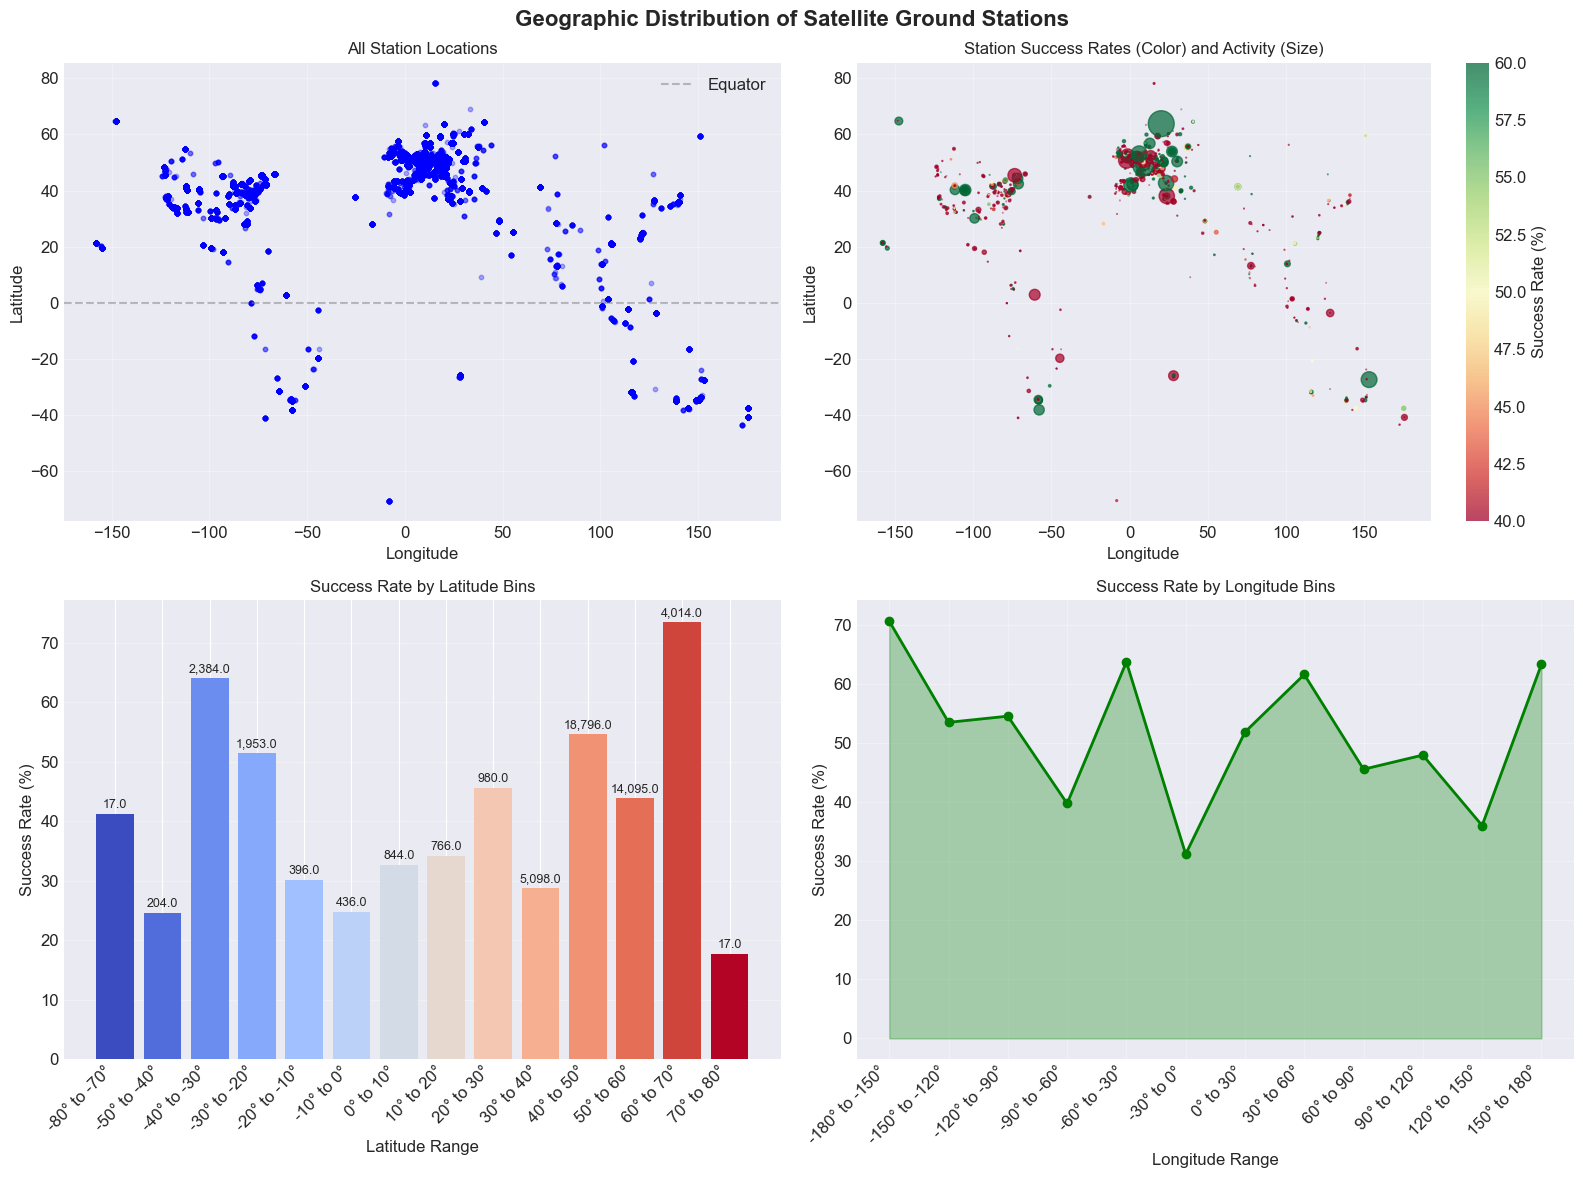

💾 Plot saved: geo_plots/01_geographic_distribution.png


In [5]:
# ============================================================================
# STEP 3: GEOGRAPHIC DISTRIBUTION VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("STEP 3: GEOGRAPHIC DISTRIBUTION VISUALIZATION")
print("="*80)

if 'station_lat' in geo_df.columns and 'station_lng' in geo_df.columns:
    print("Creating geographic visualizations...")
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Geographic Distribution of Satellite Ground Stations', 
                 fontsize=16, fontweight='bold')
    
    # 3.1 Simple station locations
    axes[0, 0].scatter(geo_df['station_lng'], geo_df['station_lat'], 
                      alpha=0.3, s=10, color='blue')
    axes[0, 0].set_xlabel('Longitude')
    axes[0, 0].set_ylabel('Latitude')
    axes[0, 0].set_title('All Station Locations', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add continent outlines (simplified)
    axes[0, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Equator')
    axes[0, 0].legend()
    
    # 3.2 Stations colored by success rate (aggregated)
    if 'target_success' in geo_df.columns:
        # Aggregate by station location
        station_stats = geo_df.groupby(['station_lat', 'station_lng']).agg({
            'target_success': ['mean', 'count']
        }).reset_index()
        
        station_stats.columns = ['station_lat', 'station_lng', 'success_rate', 'observation_count']
        station_stats['success_rate'] = station_stats['success_rate'] * 100
        
        # Plot with color by success rate
        scatter = axes[0, 1].scatter(
            station_stats['station_lng'], 
            station_stats['station_lat'], 
            c=station_stats['success_rate'],
            s=station_stats['observation_count']/10,  # Size by observation count
            cmap='RdYlGn',
            alpha=0.7,
            vmin=40, vmax=60  # Center around 50%
        )
        
        axes[0, 1].set_xlabel('Longitude')
        axes[0, 1].set_ylabel('Latitude')
        axes[0, 1].set_title('Station Success Rates (Color) and Activity (Size)', fontsize=12)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[0, 1])
        cbar.set_label('Success Rate (%)')
    
    # 3.3 Success rate by latitude bins
    if 'target_success' in geo_df.columns:
        # Create latitude bins with correct edge-label matching
        lat_bins = np.arange(-90, 91, 10)  # 19 edges
        lat_labels = [f'{lat_bins[i]}° to {lat_bins[i+1]}°' for i in range(len(lat_bins)-1)]  # 18 labels

        geo_df['lat_bin'] = pd.cut(geo_df['station_lat'], 
                           bins=lat_bins,
                           labels=lat_labels)
        
        lat_success = geo_df.groupby('lat_bin')['target_success'].agg(['mean', 'count']).dropna()
        lat_success['success_rate'] = lat_success['mean'] * 100
        
        # Plot
        bars = axes[1, 0].bar(range(len(lat_success)), lat_success['success_rate'],
                             color=cm.coolwarm(np.linspace(0, 1, len(lat_success))))
        axes[1, 0].set_xlabel('Latitude Range')
        axes[1, 0].set_ylabel('Success Rate (%)')
        axes[1, 0].set_title('Success Rate by Latitude Bins', fontsize=12)
        axes[1, 0].set_xticks(range(len(lat_success)))
        axes[1, 0].set_xticklabels(lat_success.index, rotation=45, ha='right')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # Add observation count labels
        for i, (idx, row) in enumerate(lat_success.iterrows()):
            axes[1, 0].text(i, row['success_rate'] + 0.5, 
                           f'{row["count"]:,}', 
                           ha='center', va='bottom', fontsize=9)
    
    # 3.4 Success rate by longitude bins
    if 'target_success' in geo_df.columns:
        # Fix longitude bins too (lines 86-88)
        lon_bins = np.arange(-180, 181, 30)  # 13 edges
        lon_labels = [f'{lon_bins[i]}° to {lon_bins[i+1]}°' for i in range(len(lon_bins)-1)]  # 12 labels

        geo_df['lon_bin'] = pd.cut(geo_df['station_lng'], 
                           bins=lon_bins,
                           labels=lon_labels)
        
        lon_success = geo_df.groupby('lon_bin')['target_success'].agg(['mean', 'count']).dropna()
        lon_success['success_rate'] = lon_success['mean'] * 100
        
        # Plot
        axes[1, 1].plot(range(len(lon_success)), lon_success['success_rate'],
                       marker='o', linewidth=2, color='green')
        axes[1, 1].fill_between(range(len(lon_success)), lon_success['success_rate'],
                               alpha=0.3, color='green')
        axes[1, 1].set_xlabel('Longitude Range')
        axes[1, 1].set_ylabel('Success Rate (%)')
        axes[1, 1].set_title('Success Rate by Longitude Bins', fontsize=12)
        axes[1, 1].set_xticks(range(len(lon_success)))
        axes[1, 1].set_xticklabels(lon_success.index, rotation=45, ha='right')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{geo_plot_dir}/01_geographic_distribution.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Plot saved: {geo_plot_dir}/01_geographic_distribution.png")



STEP 4: STATION ALTITUDE ANALYSIS
Analyzing station altitude effects...


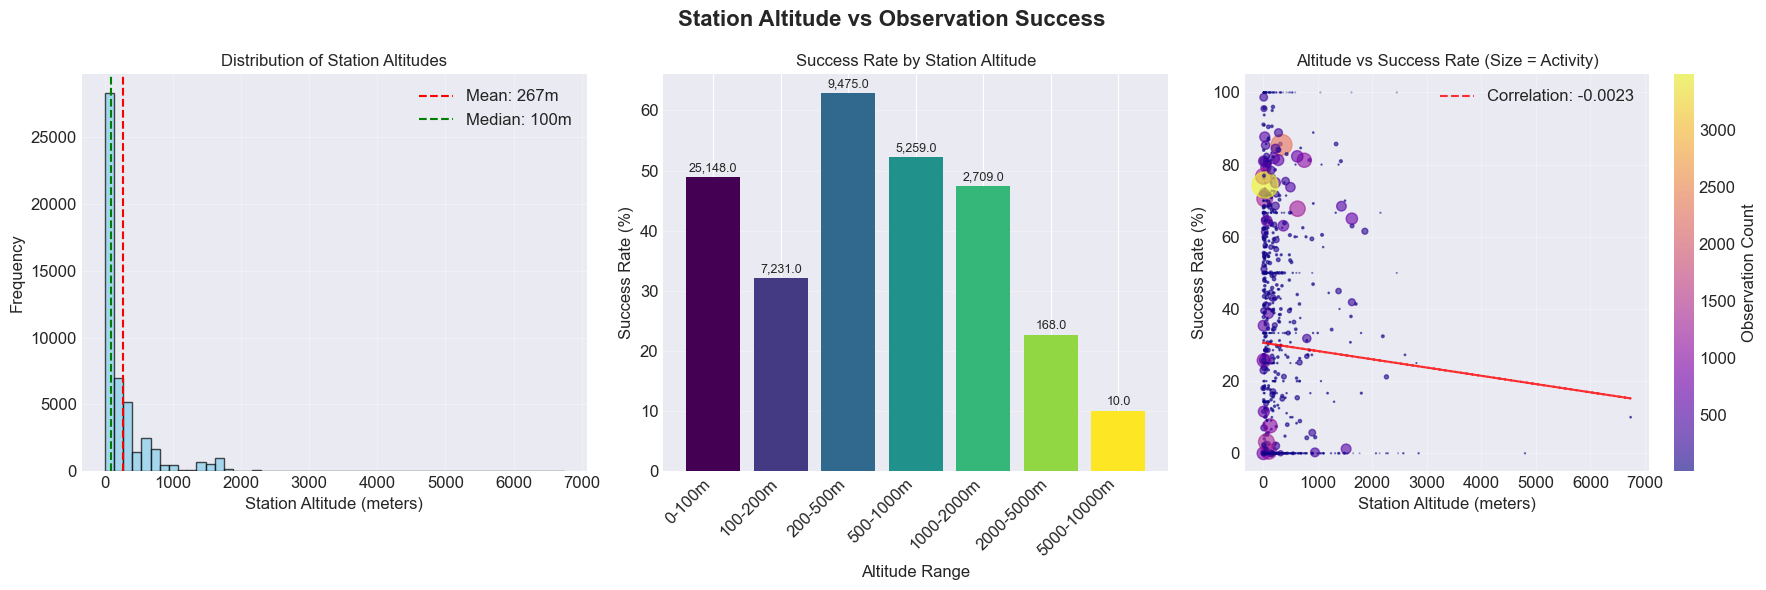

💾 Plot saved: geo_plots/02_altitude_analysis.png

📊 Altitude-Success Correlation: 0.008
   🟡 Weak positive correlation: Slight altitude advantage


In [6]:
# ============================================================================
# STEP 4: STATION ALTITUDE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("STEP 4: STATION ALTITUDE ANALYSIS")
print("="*80)

if 'station_alt' in geo_df.columns and 'target_success' in geo_df.columns:
    print("Analyzing station altitude effects...")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Station Altitude vs Observation Success', fontsize=16, fontweight='bold')
    
    # 4.1 Altitude distribution
    axes[0].hist(geo_df['station_alt'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Station Altitude (meters)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Station Altitudes', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Add statistics
    mean_alt = geo_df['station_alt'].mean()
    median_alt = geo_df['station_alt'].median()
    axes[0].axvline(mean_alt, color='red', linestyle='--', label=f'Mean: {mean_alt:.0f}m')
    axes[0].axvline(median_alt, color='green', linestyle='--', label=f'Median: {median_alt:.0f}m')
    axes[0].legend()
    
    # 4.2 Success rate by altitude bins
    # Create altitude bins
    alt_bins = [0, 100, 200, 500, 1000, 2000, 5000, 10000]
    alt_labels = [f'{alt_bins[i]}-{alt_bins[i+1]}m' for i in range(len(alt_bins)-1)]
    
    geo_df['alt_bin'] = pd.cut(geo_df['station_alt'], bins=alt_bins, labels=alt_labels)
    alt_success = geo_df.groupby('alt_bin')['target_success'].agg(['mean', 'count']).dropna()
    alt_success['success_rate'] = alt_success['mean'] * 100
    
    bars = axes[1].bar(range(len(alt_success)), alt_success['success_rate'],
                      color=cm.viridis(np.linspace(0, 1, len(alt_success))))
    axes[1].set_xlabel('Altitude Range')
    axes[1].set_ylabel('Success Rate (%)')
    axes[1].set_title('Success Rate by Station Altitude', fontsize=12)
    axes[1].set_xticks(range(len(alt_success)))
    axes[1].set_xticklabels(alt_success.index, rotation=45, ha='right')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add count labels
    for i, (idx, row) in enumerate(alt_success.iterrows()):
        axes[1].text(i, row['success_rate'] + 0.5, 
                    f'{row["count"]:,}', 
                    ha='center', va='bottom', fontsize=9)
    
    # 4.3 Scatter plot: Altitude vs Success Rate (by station)
    station_alt_stats = geo_df.groupby(['station_lat', 'station_lng', 'station_alt']).agg({
        'target_success': ['mean', 'count']
    }).reset_index()
    
    station_alt_stats.columns = ['station_lat', 'station_lng', 'station_alt', 
                                 'success_rate', 'observation_count']
    station_alt_stats['success_rate'] = station_alt_stats['success_rate'] * 100
    
    scatter = axes[2].scatter(
        station_alt_stats['station_alt'],
        station_alt_stats['success_rate'],
        s=station_alt_stats['observation_count']/10,
        c=station_alt_stats['observation_count'],
        cmap='plasma',
        alpha=0.6
    )
    
    axes[2].set_xlabel('Station Altitude (meters)')
    axes[2].set_ylabel('Success Rate (%)')
    axes[2].set_title('Altitude vs Success Rate (Size = Activity)', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    # Add correlation line
    if len(station_alt_stats) > 1:
        z = np.polyfit(station_alt_stats['station_alt'], 
                      station_alt_stats['success_rate'], 1)
        p = np.poly1d(z)
        axes[2].plot(station_alt_stats['station_alt'], 
                    p(station_alt_stats['station_alt']), 
                    "r--", alpha=0.8, label=f'Correlation: {z[0]:.4f}')
        axes[2].legend()
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[2])
    cbar.set_label('Observation Count')
    
    plt.tight_layout()
    plt.savefig(f"{geo_plot_dir}/02_altitude_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Plot saved: {geo_plot_dir}/02_altitude_analysis.png")
    
    # Calculate altitude-success correlation
    alt_corr = geo_df['station_alt'].corr(geo_df['target_success'])
    print(f"\n📊 Altitude-Success Correlation: {alt_corr:.3f}")
    
    if alt_corr > 0.1:
        print("   🟢 Moderate positive correlation: Higher altitude stations tend to have better success")
    elif alt_corr > 0:
        print("   🟡 Weak positive correlation: Slight altitude advantage")
    elif alt_corr < 0:
        print("   🔴 Negative correlation: Higher altitude stations may have worse success")
    else:
        print("   ⚪ No correlation: Altitude doesn't affect success rate")



STEP 5: STATION HORIZON ANALYSIS
Analyzing station horizon effects...


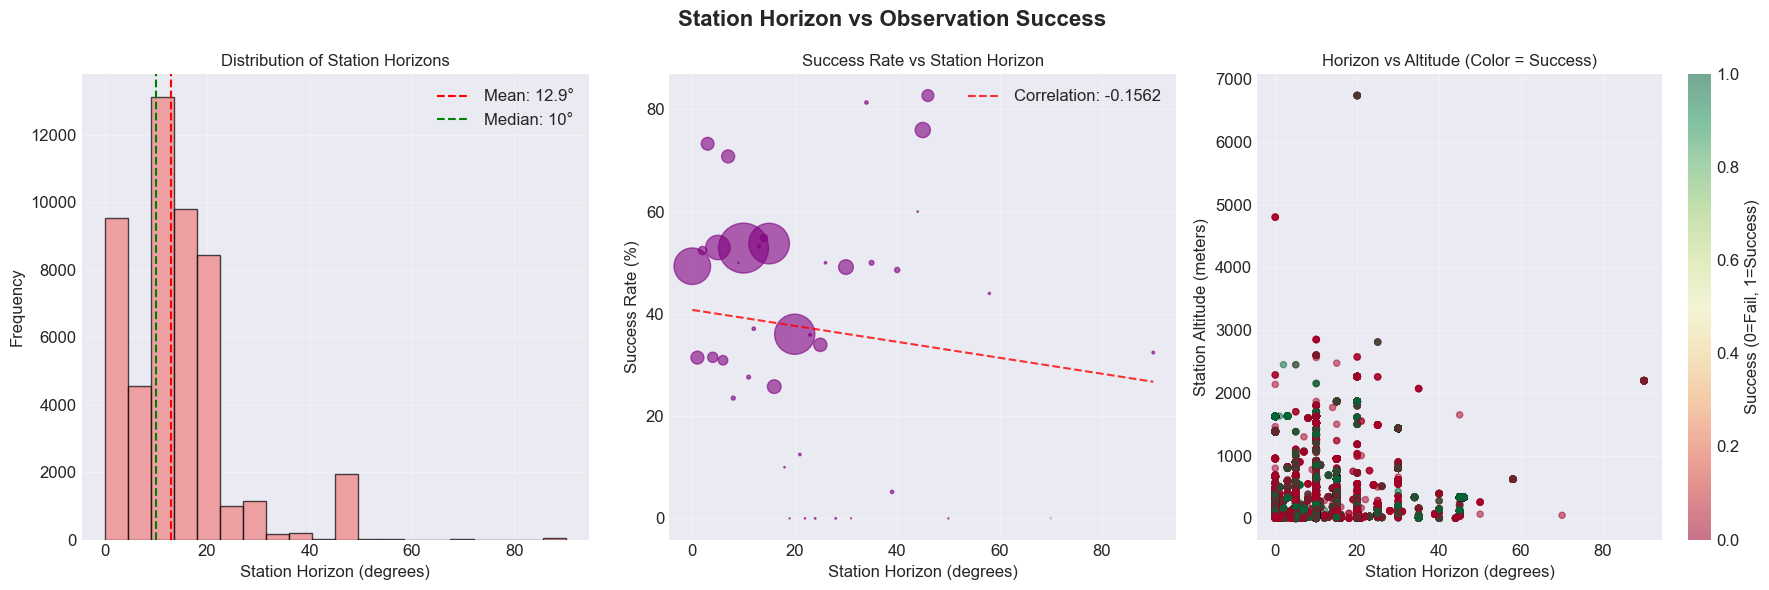

💾 Plot saved: geo_plots/03_horizon_analysis.png

📊 Horizon-Success Correlation: 0.021
   🟡 Weak positive correlation: Slight horizon advantage


In [7]:
# ============================================================================
# STEP 5: STATION HORIZON ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: STATION HORIZON ANALYSIS")
print("="*80)

if 'horizon' in geo_df.columns and 'target_success' in geo_df.columns:
    print("Analyzing station horizon effects...")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Station Horizon vs Observation Success', fontsize=16, fontweight='bold')
    
    # 5.1 Horizon distribution
    axes[0].hist(geo_df['horizon'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Station Horizon (degrees)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Station Horizons', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Add statistics
    mean_horizon = geo_df['horizon'].mean()
    median_horizon = geo_df['horizon'].median()
    axes[0].axvline(mean_horizon, color='red', linestyle='--', label=f'Mean: {mean_horizon:.1f}°')
    axes[0].axvline(median_horizon, color='green', linestyle='--', label=f'Median: {median_horizon:.0f}°')
    axes[0].legend()
    
    # 5.2 Success rate by horizon
    horizon_success = geo_df.groupby('horizon')['target_success'].agg(['mean', 'count']).reset_index()
    horizon_success['success_rate'] = horizon_success['mean'] * 100
    
    axes[1].scatter(horizon_success['horizon'], horizon_success['success_rate'],
                   s=horizon_success['count']/10, alpha=0.6, color='purple')
    axes[1].set_xlabel('Station Horizon (degrees)')
    axes[1].set_ylabel('Success Rate (%)')
    axes[1].set_title('Success Rate vs Station Horizon', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    # Add correlation line
    if len(horizon_success) > 1:
        z = np.polyfit(horizon_success['horizon'], horizon_success['success_rate'], 1)
        p = np.poly1d(z)
        axes[1].plot(horizon_success['horizon'], p(horizon_success['horizon']), 
                    "r--", alpha=0.8, label=f'Correlation: {z[0]:.4f}')
        axes[1].legend()
    
    # 5.3 Horizon vs Altitude scatter
    scatter = axes[2].scatter(
        geo_df['horizon'],
        geo_df['station_alt'],
        c=geo_df['target_success'],
        cmap='RdYlGn',
        alpha=0.5,
        s=20
    )
    axes[2].set_xlabel('Station Horizon (degrees)')
    axes[2].set_ylabel('Station Altitude (meters)')
    axes[2].set_title('Horizon vs Altitude (Color = Success)', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[2])
    cbar.set_label('Success (0=Fail, 1=Success)')
    
    plt.tight_layout()
    plt.savefig(f"{geo_plot_dir}/03_horizon_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Plot saved: {geo_plot_dir}/03_horizon_analysis.png")
    
    # Calculate horizon-success correlation
    horizon_corr = geo_df['horizon'].corr(geo_df['target_success'])
    print(f"\n📊 Horizon-Success Correlation: {horizon_corr:.3f}")
    
    if horizon_corr > 0.1:
        print("   🟢 Moderate positive correlation: Higher horizons (lower min elevation) help")
    elif horizon_corr > 0:
        print("   🟡 Weak positive correlation: Slight horizon advantage")
    elif horizon_corr < 0:
        print("   🔴 Negative correlation: Higher horizons may hurt success")
    else:
        print("   ⚪ No correlation: Horizon doesn't affect success rate")



STEP 6: GRID SQUARE ANALYSIS (REGIONAL PATTERNS)
Analyzing regional patterns using Maidenhead grid squares...

📊 Top 10 Regions by Observation Count:
    1. KP03:  3,473 obs,  74.7% success
    2. JN48:  2,312 obs,  83.7% success
    3. JN02:  1,722 obs,  81.1% success
    4. KM18:  1,438 obs,   9.7% success
    5. IO80:  1,307 obs,   3.1% success
    6. JO33:  1,297 obs,  76.6% success
    7. QG62:  1,293 obs,  70.5% success
    8. KN12:  1,278 obs,  65.9% success
    9. DN70:  1,177 obs,  59.6% success
   10. IO92:  1,157 obs,   6.8% success

🏆 Top 5 Regions by Success Rate:
    1. KO33:  83.9% success (1,033 obs)
    2. JN48:  83.7% success (2,312 obs)
    3. KO50:  81.8% success (633 obs)
    4. JN02:  81.1% success (1,722 obs)
    5. GF11:  81.0% success (547 obs)


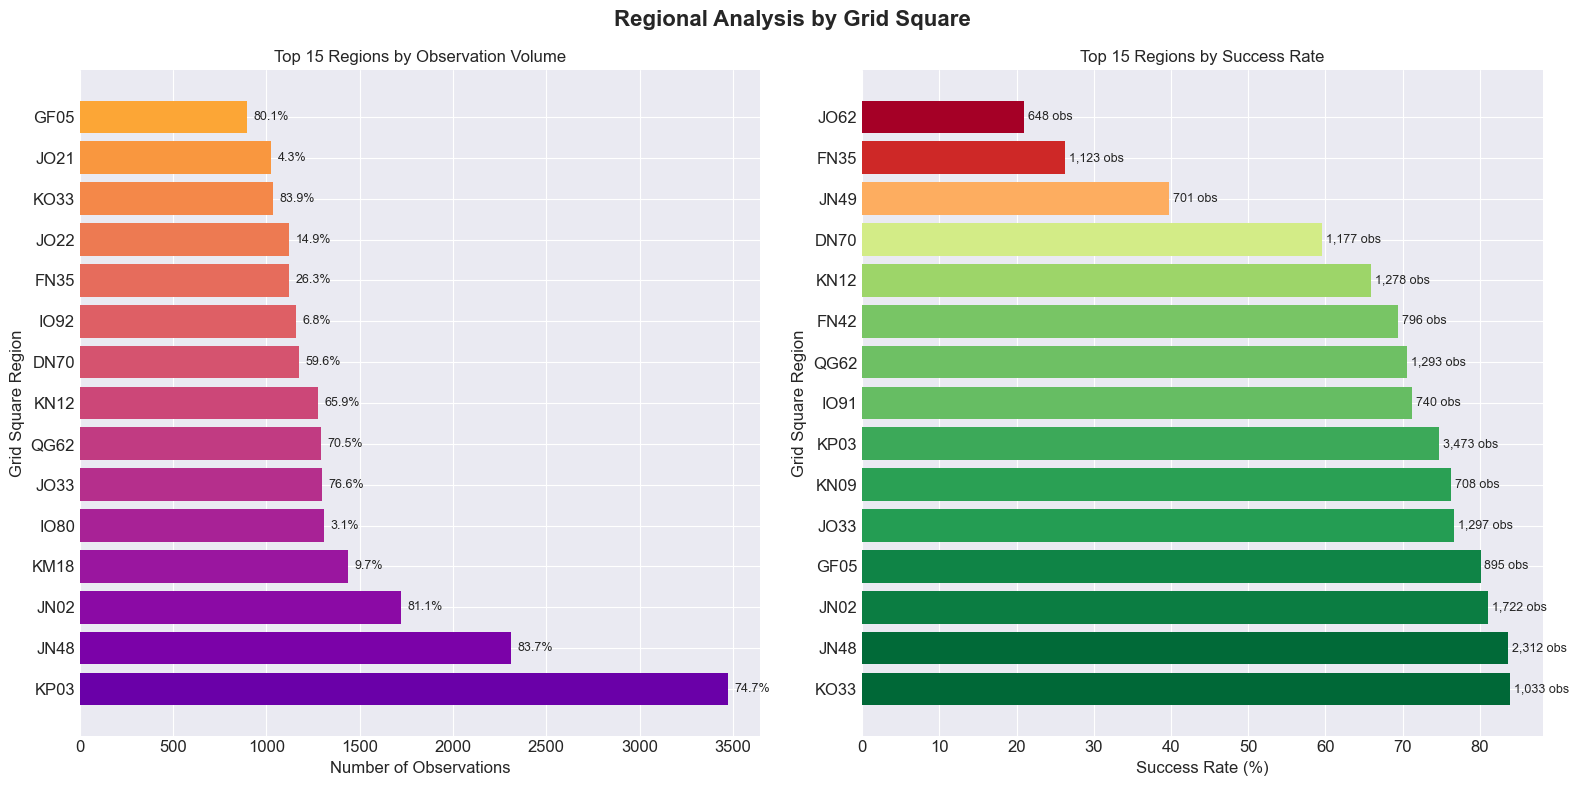

💾 Plot saved: geo_plots/04_regional_analysis.png


In [8]:
# ============================================================================
# STEP 6: GRID SQUARE ANALYSIS (REGIONAL PATTERNS)
# ============================================================================
print("\n" + "="*80)
print("STEP 6: GRID SQUARE ANALYSIS (REGIONAL PATTERNS)")
print("="*80)

if 'grid_square' in geo_df.columns and 'target_success' in geo_df.columns:
    print("Analyzing regional patterns using Maidenhead grid squares...")
    
    # Extract first 4 characters for regional analysis
    geo_df['grid_region'] = geo_df['grid_square'].str[:4]
    
    # Get top regions by observation count
    region_stats = geo_df.groupby('grid_region')['target_success'].agg(['mean', 'count']).reset_index()
    region_stats = region_stats[region_stats['count'] >= 100]  # Minimum observations
    region_stats['success_rate'] = region_stats['mean'] * 100
    
    if len(region_stats) > 5:
        print(f"\n📊 Top {min(10, len(region_stats))} Regions by Observation Count:")
        top_regions = region_stats.nlargest(10, 'count')
        for i, (_, row) in enumerate(top_regions.iterrows(), 1):
            print(f"   {i:2}. {row['grid_region']}: {row['count']:6,} obs, {row['success_rate']:5.1f}% success")
        
        print(f"\n🏆 Top {min(5, len(region_stats))} Regions by Success Rate:")
        best_regions = region_stats.nlargest(5, 'success_rate')
        for i, (_, row) in enumerate(best_regions.iterrows(), 1):
            print(f"   {i:2}. {row['grid_region']}: {row['success_rate']:5.1f}% success ({row['count']:,} obs)")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle('Regional Analysis by Grid Square', fontsize=16, fontweight='bold')
        
        # Top regions by count
        top_n = min(15, len(region_stats))
        top_by_count = region_stats.nlargest(top_n, 'count')
        
        bars1 = axes[0].barh(range(top_n), top_by_count['count'].values,
                            color=cm.plasma(np.linspace(0.2, 0.8, top_n)))
        axes[0].set_xlabel('Number of Observations')
        axes[0].set_ylabel('Grid Square Region')
        axes[0].set_title(f'Top {top_n} Regions by Observation Volume', fontsize=12)
        axes[0].set_yticks(range(top_n))
        axes[0].set_yticklabels(top_by_count['grid_region'].values)
        
        # Add success rate as text
        for i, (idx, row) in enumerate(top_by_count.iterrows()):
            axes[0].text(row['count'] + max(top_by_count['count'])*0.01, i,
                        f"{row['success_rate']:.1f}%", 
                        va='center', fontsize=9)
        
        # Top regions by success rate (with minimum observations)
        min_obs = region_stats['count'].quantile(0.75)  # Top 25% by count
        qualified = region_stats[region_stats['count'] >= min_obs]
        
        if len(qualified) > 5:
            top_by_success = qualified.nlargest(top_n, 'success_rate')
            
            colors = cm.RdYlGn((top_by_success['success_rate'] - 
                              top_by_success['success_rate'].min()) / 
                             (top_by_success['success_rate'].max() - 
                              top_by_success['success_rate'].min()))
            
            bars2 = axes[1].barh(range(len(top_by_success)), top_by_success['success_rate'].values,
                                color=colors)
            axes[1].set_xlabel('Success Rate (%)')
            axes[1].set_ylabel('Grid Square Region')
            axes[1].set_title(f'Top {len(top_by_success)} Regions by Success Rate', fontsize=12)
            axes[1].set_yticks(range(len(top_by_success)))
            axes[1].set_yticklabels(top_by_success['grid_region'].values)
            
            # Add observation count as text
            for i, (idx, row) in enumerate(top_by_success.iterrows()):
                axes[1].text(row['success_rate'] + 0.5, i,
                            f"{row['count']:,} obs", 
                            va='center', fontsize=9)
        
        plt.tight_layout()
        plt.savefig(f"{geo_plot_dir}/04_regional_analysis.png", dpi=150, bbox_inches='tight')
        plt.show()
        print(f"💾 Plot saved: {geo_plot_dir}/04_regional_analysis.png")


STEP 7: MULTIVARIATE GEOGRAPHIC ANALYSIS
Analyzing combined geographic effects...


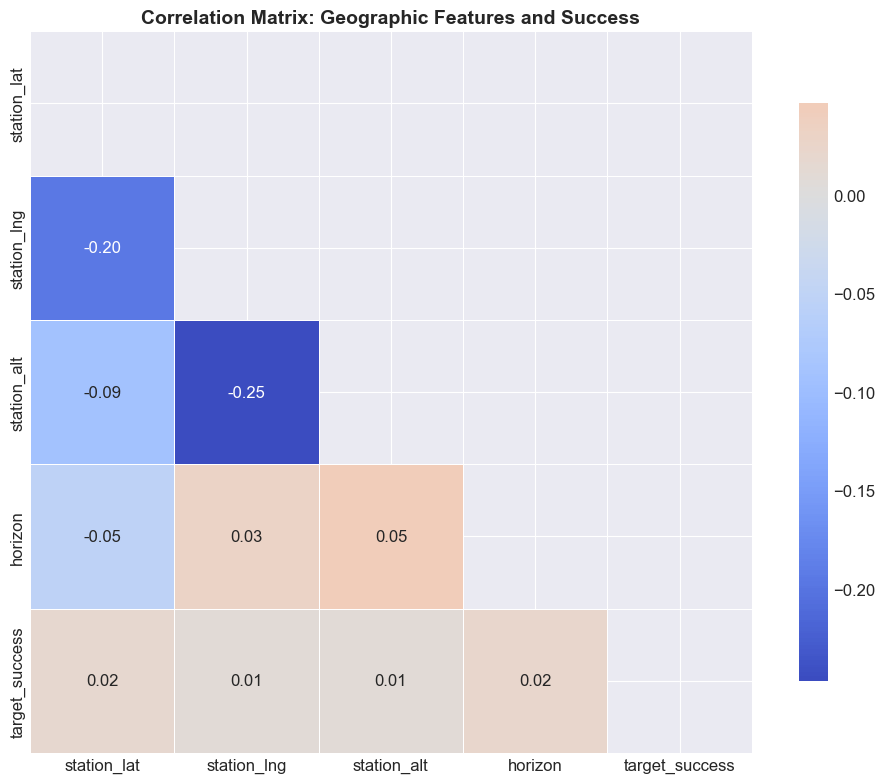

💾 Plot saved: geo_plots/05_geographic_correlations.png

📊 Geographic Feature Correlations with Success:
   • station_lat    :   0.019
   • station_lng    :   0.008
   • station_alt    :   0.008
   • horizon        :   0.021

🔍 Identifying Geographic Success Clusters...
   Found 10 high-success geographic clusters
   Average success in clusters: 82.9%
   vs Global average: 49.3%


In [9]:
# ============================================================================
# STEP 7: MULTIVARIATE GEOGRAPHIC ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("STEP 7: MULTIVARIATE GEOGRAPHIC ANALYSIS")
print("="*80)

print("Analyzing combined geographic effects...")

if all(col in geo_df.columns for col in ['station_lat', 'station_alt', 'horizon', 'target_success']):
    # Create a correlation matrix of geographic features
    geo_features = ['station_lat', 'station_lng', 'station_alt', 'horizon', 'target_success']
    geo_corr = geo_df[geo_features].corr()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(geo_corr, dtype=bool))
    sns.heatmap(geo_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8},
                ax=ax)
    ax.set_title('Correlation Matrix: Geographic Features and Success', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{geo_plot_dir}/05_geographic_correlations.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Plot saved: {geo_plot_dir}/05_geographic_correlations.png")
    
    print("\n📊 Geographic Feature Correlations with Success:")
    for feature in ['station_lat', 'station_lng', 'station_alt', 'horizon']:
        if feature in geo_corr.columns:
            corr = geo_corr.loc[feature, 'target_success']
            print(f"   • {feature:15}: {corr:7.3f}")
    
    # Identify geographic clusters of successful stations
    print("\n🔍 Identifying Geographic Success Clusters...")
    
    # Calculate success rate by latitude-longitude bins
    geo_df['lat_bin'] = pd.cut(geo_df['station_lat'], bins=20)
    geo_df['lon_bin'] = pd.cut(geo_df['station_lng'], bins=20)
    
    cluster_stats = geo_df.groupby(['lat_bin', 'lon_bin'])['target_success'].agg(['mean', 'count']).reset_index()
    cluster_stats['success_rate'] = cluster_stats['mean'] * 100
    
    # Find high-success clusters (top 10% by success rate with minimum observations)
    min_obs_for_cluster = cluster_stats['count'].quantile(0.5)
    high_success_clusters = cluster_stats[
        (cluster_stats['success_rate'] > cluster_stats['success_rate'].quantile(0.9)) &
        (cluster_stats['count'] > min_obs_for_cluster)
    ]
    
    if len(high_success_clusters) > 0:
        print(f"   Found {len(high_success_clusters)} high-success geographic clusters")
        print(f"   Average success in clusters: {high_success_clusters['success_rate'].mean():.1f}%")
        print(f"   vs Global average: {geo_df['target_success'].mean()*100:.1f}%")

In [11]:
# ============================================================================
# STEP 8: SUMMARY AND RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("STEP 8: SUMMARY AND RECOMMENDATIONS")
print("="*80)

print("📋 GEOGRAPHIC ANALYSIS SUMMARY")
print("=" * 60)

# Collect key insights
insights = []

if 'station_lat' in geo_df.columns:
    # Hemisphere insights
    northern_success = geo_df[geo_df['station_lat'] >= 0]['target_success'].mean() * 100
    southern_success = geo_df[geo_df['station_lat'] < 0]['target_success'].mean() * 100
    hemisphere_diff = abs(northern_success - southern_success)
    
    insights.append(f"1. Hemisphere Difference: {hemisphere_diff:.1f}pp")
    if northern_success > southern_success:
        insights.append(f"   → Northern hemisphere performs better ({northern_success:.1f}% vs {southern_success:.1f}%)")
    else:
        insights.append(f"   → Southern hemisphere performs better ({southern_success:.1f}% vs {northern_success:.1f}%)")

if 'station_alt' in geo_df.columns:
    alt_corr = geo_df['station_alt'].corr(geo_df['target_success'])
    insights.append(f"2. Altitude Correlation: {alt_corr:.3f}")
    if alt_corr > 0.05:
        insights.append(f"   → Higher altitude stations have better success rates")
    elif alt_corr < -0.05:
        insights.append(f"   → Lower altitude stations have better success rates")
    else:
        insights.append(f"   → Altitude has minimal effect on success")

if 'horizon' in geo_df.columns:
    horizon_corr = geo_df['horizon'].corr(geo_df['target_success'])
    insights.append(f"3. Horizon Correlation: {horizon_corr:.3f}")
    if horizon_corr > 0.05:
        insights.append(f"   → Stations with higher horizons (lower min elevation) perform better")
    elif horizon_corr < -0.05:
        insights.append(f"   → Stations with lower horizons (higher min elevation) perform better")
    else:
        insights.append(f"   → Horizon has minimal effect on success")

if 'grid_square' in geo_df.columns:
    region_stats = geo_df.groupby('grid_square')['target_success'].agg(['mean', 'count'])
    best_region = region_stats['mean'].idxmax()
    best_success = region_stats.loc[best_region, 'mean'] * 100
    insights.append(f"4. Best Performing Region: {best_region}")
    insights.append(f"   → Success rate: {best_success:.1f}%")

# Print all insights
for insight in insights:
    print(f"   {insight}")

print("\n🎯 IMPLICATIONS FOR SATELLITE NETWORK PLANNING:")
print("   1. **Station Placement**: Consider geographic patterns when deploying new stations")
print("   2. **Altitude Effects**: Higher altitude may provide advantages")
print("   3. **Regional Optimization**: Learn from high-success regions")
print("   4. **Network Diversity**: Balance stations across hemispheres and regions")

print("\n🚀 RECOMMENDED NEXT STEPS:")
print("   1. **Deep Dive**: Analyze specific high-success regions in detail")
print("   2. **Time-Geography Interaction**: Combine temporal and geographic patterns")
print("   3. **Satellite-Specific Analysis**: Which satellites work best in which regions?")
print("   4. **ML Feature Engineering**: Create geographic features for modeling")

# Save summary report
summary = f"""
# GEOGRAPHIC ANALYSIS REPORT - Satellite Ground Stations
**Generated**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Dataset**: {len(geo_df):,} observations with geographic data
**Overall Success Rate**: {geo_df['target_success'].mean()*100:.2f}%

## KEY FINDINGS
{chr(10).join([f"- {insight}" for insight in insights])}

## VISUALIZATIONS CREATED
1. `01_geographic_distribution.png` - Station locations and success rates
2. `02_altitude_analysis.png` - Altitude effects on success
3. `03_horizon_analysis.png` - Horizon effects on success
4. `04_regional_analysis.png` - Regional patterns by grid square
5. `05_geographic_correlations.png` - Feature correlation matrix

## RECOMMENDATIONS
1. Consider geographic patterns in station deployment
2. Monitor altitude effects on observation quality
3. Learn from high-success geographic clusters
4. Balance network across hemispheres for coverage

## NEXT STEPS
1. Combine temporal and geographic insights
2. Create composite geographic features for ML
3. Analyze satellite-specific geographic preferences
"""

report_path = "geographic_analysis_report.md"
with open(report_path, "w", encoding="utf-8") as f:
    f.write(summary)

print(f"\n📄 Summary report saved: {report_path}")
print(f"📊 Visualizations saved in: {geo_plot_dir}/")



STEP 8: SUMMARY AND RECOMMENDATIONS
📋 GEOGRAPHIC ANALYSIS SUMMARY
   1. Hemisphere Difference: 3.2pp
      → Southern hemisphere performs better (52.2% vs 49.0%)
   2. Altitude Correlation: 0.008
      → Altitude has minimal effect on success
   3. Horizon Correlation: 0.021
      → Horizon has minimal effect on success
   4. Best Performing Region: CN96pm
      → Success rate: 100.0%

🎯 IMPLICATIONS FOR SATELLITE NETWORK PLANNING:
   1. **Station Placement**: Consider geographic patterns when deploying new stations
   2. **Altitude Effects**: Higher altitude may provide advantages
   3. **Regional Optimization**: Learn from high-success regions
   4. **Network Diversity**: Balance stations across hemispheres and regions

🚀 RECOMMENDED NEXT STEPS:
   1. **Deep Dive**: Analyze specific high-success regions in detail
   2. **Time-Geography Interaction**: Combine temporal and geographic patterns
   3. **Satellite-Specific Analysis**: Which satellites work best in which regions?
   4. **M

In [12]:
# ============================================================================
# COMPLETION
# ============================================================================
print("\n" + "="*80)
print("✅ GEOGRAPHIC ANALYSIS COMPLETE!")
print("="*80)

print(f"\n🎯 Key outputs created:")
print(f"   1. {report_path} - Geographic analysis report")
print(f"   2. {geo_plot_dir}/ - Directory with 5 geographic visualization plots")

print(f"\n📊 Geographic insights uncovered:")
print(f"   • Hemisphere performance differences")
print(f"   • Altitude-success relationships")
print(f"   • Regional success patterns")

print(f"\n⏱️  Analysis completed at: {datetime.now().strftime('%H:%M:%S')}")

print("\n" + "="*80)
print("🌍 Ready for Advanced Analysis & ML Feature Engineering!")
print("="*80)


✅ GEOGRAPHIC ANALYSIS COMPLETE!

🎯 Key outputs created:
   1. geographic_analysis_report.md - Geographic analysis report
   2. geo_plots/ - Directory with 5 geographic visualization plots

📊 Geographic insights uncovered:
   • Hemisphere performance differences
   • Altitude-success relationships
   • Regional success patterns

⏱️  Analysis completed at: 14:26:26

🌍 Ready for Advanced Analysis & ML Feature Engineering!
